In [37]:
import cv2
import numpy as np
import torch
import torchvision.transforms.functional as F
from matplotlib import pyplot as plt
from torchvision.io import decode_image

from wings.config import MODELS_DIR, PROCESSED_DATA_DIR, RAW_DATA_DIR, IMG_FOLDER_SUFX
from wings.modeling.litnet import LitNet
from wings.modeling.loss import DiceLoss

In [2]:
test_dataset = torch.load(PROCESSED_DATA_DIR / "mask_datasets" / "test_mask_dataset.pth", weights_only=False)
checkpoint_path = MODELS_DIR / 'unet-epoch=05-val_loss=0.11-unet-training_1.ckpt'
unet_model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False
)
num_epochs = 60
model = LitNet.load_from_checkpoint(checkpoint_path, model=unet_model, num_epochs=num_epochs, criterion=DiceLoss())
model.eval()

max_n = len(test_dataset)

Using cache found in /home/mkrajew/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


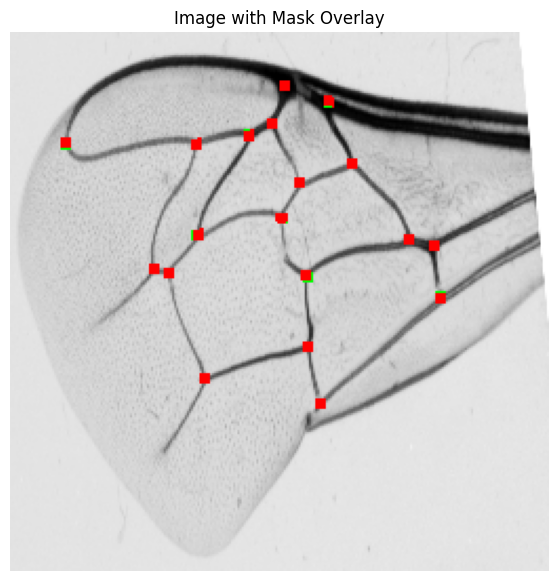

In [119]:
n = np.random.randint(0, max_n)
image, label = test_dataset[n]
original_dataset = test_dataset.dataset  # this gives you the original dataset
filename = original_dataset.coords_df.loc[test_dataset.indices[n], 'file']
output = model(image.cuda().unsqueeze(0))

country = filename.split('-', 1)[0]
img = decode_image(str(RAW_DATA_DIR / f"{country}{IMG_FOLDER_SUFX}" / filename))
img = F.resize(img, [256, 256], interpolation=F.InterpolationMode.BILINEAR, antialias=False)
img = img.numpy().transpose(1, 2, 0)

mask = torch.round(output).squeeze().detach().cpu().numpy()
labels = torch.round(label).squeeze().detach().cpu().numpy()
# _, ax = plt.subplots(1, 2, figsize=(10, 10))
# ax[0].imshow(img, cmap="gray")
# ax[0].set_title("image")
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# ax[1].imshow(mask, cmap="gray")
# ax[1].set_title("mask")
# ax[1].set_xticks([])
# ax[1].set_yticks([])

image_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Create boolean mask for white pixels in mask
white_areas = mask == 1
target_areas = labels == 1

# Set those areas to red (BGR: [0, 0, 255])
image_bgr[target_areas] = [0, 255, 0]
image_bgr[white_areas] = [0, 0, 255]

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Show the result
plt.figure(figsize=(7, 7))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Image with Mask Overlay")
plt.show()
